
# Model Evaluation & Validation


## Data

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

Run the code cell below to load the Boston housing dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.cross_validation import ShuffleSplit
import matplotlib.pyplot as plt

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print "Boston housing dataset has {} data points with {} variables each.".format(*data.shape)

Boston housing dataset has 489 data points with 4 variables each.


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


## Data Exploration

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Implementation: Calculate Statistics

In [2]:
# TODO: Minimum price of the data
minimum_price = np.min(prices)

# TODO: Maximum price of the data
maximum_price = np.max(prices)

# TODO: Mean price of the data
mean_price = np.mean(prices)

# TODO: Median price of the data
median_price = np.median(prices)

# TODO: Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print "Statistics for Boston housing dataset:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13


### Question 1 - Feature Observation
As a reminder, we are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.


               RM     LSTAT   PTRATIO      MEDV
RM       1.000000 -0.612033 -0.304559  0.697209
LSTAT   -0.612033  1.000000  0.360445 -0.760670
PTRATIO -0.304559  0.360445  1.000000 -0.519034
MEDV     0.697209 -0.760670 -0.519034  1.000000


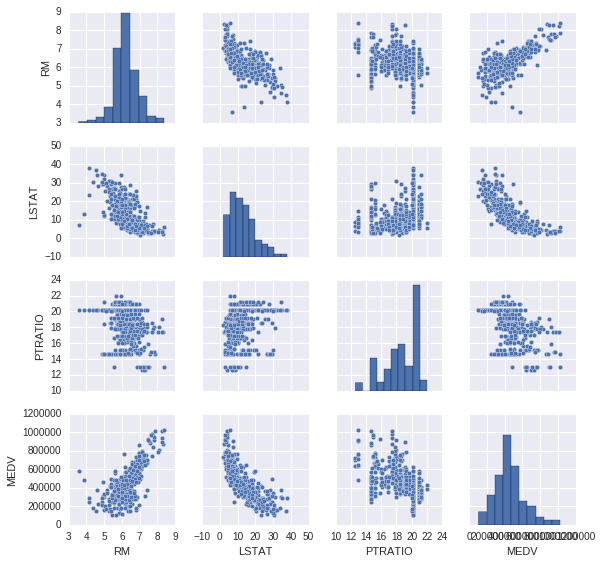

In [3]:
import seaborn as sns   
sns.set() 
print data.corr()
sns.pairplot(data, size=2)
plt.show()

The 'RM' variable can be seen as a proxy for house size and thus, its production cost. I than expect 'RM' and 'MEDV' to be positively correlated (as one increases, so does the other). 'LSTAT' can be seen as a proxy of population (inverse of) wealth. As known by microeconomic theory, price and population wealth are positively correlated. Hence, I expect that as 'LSTAT' increase, 'MEDV' should decrease. At last, its not immediately clear how 'PTRATIO' can influence housing price. One could see 'PTRATIO' as some measure of fertility and establish some connection between hight fertility and preference for bigger houses, but that is just a conjecture.  
If we explore further using visual analyses, we can see that 'PTRATIO' is negatively correlated with 'MEDV'; directly printing the numerical correlation confirms that more precisely. It is still not clear why that is the case. From the plots above we can also note that 'PTRATIO' and 'LSTAT' are positively correlated, and since 'LSTAT' and 'MEDV' are negatively correlated (as discussed above), we can conjecture that 'PTRATIO' captures another kind of population (inverse) wealth measure. That actually makes sense, if we consider that poorer populations have less resources to hire teachers, having thus a higher 'PTRATIO'. 

----

## Developing a Model


### Implementation: Define a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, you will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify your model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._


In [4]:
# TODO: Import 'r2_score'
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### Question 2 - Goodness of Fit
Assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |


In [5]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print "Model has a coefficient of determination, R^2, of {:.3f}.".format(score)

Model has a coefficient of determination, R^2, of 0.923.


Defining x as our independent variable and y as our dependent variable, as explained in Wooldridge (2012) "$R^2$ is the ratio of the explained variation compared to the total variation; thus, it is interpreted as the fraction of the sample variation in y that is explained by x". Furthermore,  $R^2 \equiv SSE/SST = 1- SSR/SST$,  
in witch $SSE \equiv \sum({\hat{y}-\bar{y}})^2$ is the explained sum of squares,  
$SST \equiv \sum({y_i-\bar{y}})^2$ is the total sum of squares and  
$SSR \equiv \sum{\hat{u}^2}$ is the residual sum of squares.

Essentially, $R^2$ measures how the true and predicted values move together. 
In a more informal way, we can interpret the $R^2$ score as the fraction of the sample variation in y that is explained by our model. 


As shown by the $R^2=0.923$, the model seems to have capture well the variation in the target variable. In other words, we can say that the model explains 92.3% of the variation in the target variable.

### Implementation: Shuffle and Split Data


In [6]:
# TODO: Import 'train_test_split'
from sklearn.model_selection import train_test_split

# TODO: Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=.2, random_state=42)

# Success
print "Training and testing split was successful."

Training and testing split was successful.


### Question 3 - Training and Testing


Machine learning models can have very hight capacity and learn noise in the data that arise from sampling error and other sources. As a result, the performance on the training data can be arbitrarily high just by rising the model capacity. However, this kind of models tend to have high variance and usually fail to generalize well. This means that they perform poorly on new (not seen) data. To see how our model perform in new data, we can split our data in multiple sets: a training set to train the model, a validation set to tune hyper-parameters and a test set to see the true performance of the model or how it is likely to perform in the real world data.


## Analyzing Model Performance


### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  


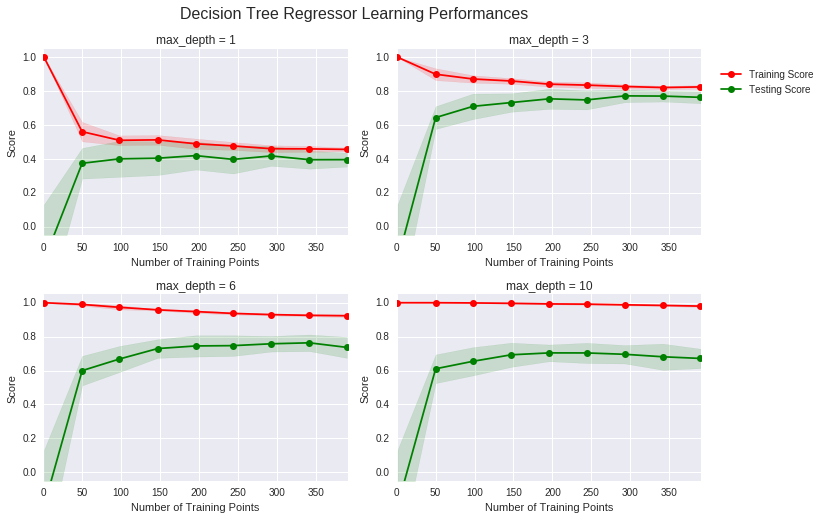

In [7]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### Learning the Data


For the model with max_depth = 3 we can see that training score beging very high ($R^2$ around 1.0) with a small number of training points and goes down as we add more training points; it eventualy plateaus around $R^2=0.80$ when we get at 300 training points. On the other hand, the testing curve begins very low ($R^2$ < 0.0) with a small number of trainig points and goes up as we add more training points; it eventualy plateaus around $R^2=0.80$ when we get at 300 training points.  

For this model, the learning curve for training and test converge at around $R^2=0.80$ and plateaus; that happens when we have 300 training points. We can see that going from 300 to 400 trainig points have little efect in both curves, so it is no likely that having more training points will benefit the model.

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  


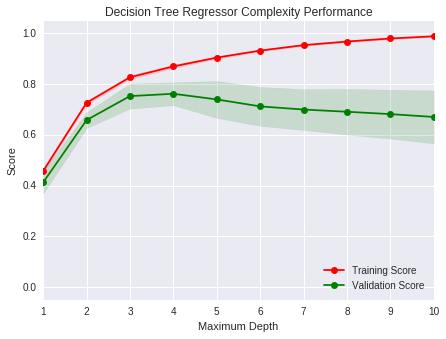

In [8]:
vs.ModelComplexity(X_train, y_train)

### Bias-Variance Tradeoff


We can think of maximum depth as a measure of model capacity. When it is to low, the model doesn't have enough capacity to fit the regularity in the data; in other words, it has high bias. When complexity increases, the model starts to learn noise in the data and suffers from high variance.  
  
When maximum depth is 10, we can see from the high training score that it can fit the training data almost perfectly; 
we can also see that the validation score is low at max_depth=10. These are cues that the model is suffering from high variance and learning noise in the training data.  
  
When maximum depth is 1, we can see that both training and validation score are low. These are cues that the model is suffering from high bias and that it does not have enough capacity to fit the regularities in the training data. 

-----

## Evaluating Model Performance


### Grid Search

The grid search is a method for tuning models hyper parameters. It performs an exhaustive search in a gird of specified hyper-parameters and returns the combination that has the lowest validation error. As described by Goodfellow et al (2016), "for each hyper-parameter, the user selects a small ﬁnite set of values to explore. The grid search algorithm then trains a model for every joint speciﬁcation of hyper-parameter values in the Cartesian product of the set of values for each individual hyper parameter. The experiment that yields the best validation set error is then chosen as having found the best hyper-parameters".

### Cross-Validation


  
(https://www.cs.cmu.edu/~schneide/tut5/node42.html), with simple holdout validation method, "evaluation can have a high variance. The evaluation may depend heavily on which data points end up in the training set and which end up in the test set, and thus the evaluation may be significantly different depending on how the division is made."  K-fold cross validation is a way to improve the simple holdout validation method. In k-fold cross validation we first split the data into k different subsets and repeat k holdout validation experiments, each time picking one of the k subsets as the validation set and the other k-1 subsets as training set. The validation performance is then averaged across all k experiments to obtain an estimator of the test error. It is important to note that "there exist no unbiased estimators of the variance of such average error estimators (Bengio and Grandvalet, 2004), but approximations are typically used (Goodfellow et al, 2016).
  
One advantage of this approach is that every data point can be used for validation exactly one time and k-1 times for training, thus mitigating the trade-off between train and validation test sizes (we can use all our data to train and to test, but we still have to perform a train-test split, hence the trade-off does not disappear completely). Another advantage of k-fold cross validation is that the variance of the resulting performance estimate is reduced as k is increased. However, note that "as K increases, the percentage of training instances increases and we get more robust estimators, but the validation set becomes smaller" (Alpaydın, 2014).

As grid search is a method for automatic hyper-parameter optimization based on validation metrics, k-fold cross validation can help grid search in the validation metrics part. It can also place a confidence interval (even if only a biased one) around the point estimate of the validation metrics.

### Implementation: Fitting a Model

In [9]:
# TODO: Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    # TODO: Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # TODO: Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':range(1,11)}
    
    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # TODO: Create the grid search object
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. You can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

### Optimal Model


In [10]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])
print "The R^2 for the optimal model is: %f" % reg.score(X_test, y_test)

Parameter 'max_depth' is 4 for the optimal model.
The R^2 for the optimal model is: 0.844000


### Predicting Selling Prices
Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |
*What price would you recommend each client sell his/her home at? Do these prices seem reasonable given the values for the respective features?*  


In [11]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print "Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price)

Predicted selling price for Client 1's home: $403,025.00
Predicted selling price for Client 2's home: $237,478.72
Predicted selling price for Client 3's home: $931,636.36


In [12]:
data.describe()

,RM,LSTAT,PTRATIO,MEDV
count,489.000000,489.000000,489.000000,4.890000e+02
mean,6.240288,12.939632,18.516564,4.543429e+05
std,0.643650,7.081990,2.111268,1.653403e+05
min,3.561000,1.980000,12.600000,1.050000e+05
25%,5.880000,7.370000,17.400000,3.507000e+05
50%,6.185000,11.690000,19.100000,4.389000e+05
75%,6.575000,17.120000,20.200000,5.187000e+05
max,8.398000,37.970000,22.000000,1.024800e+06


**Answer: **  I would recommend for client 1, 2 and 3 to sell his/her home for \$403,025.00, \$237,478.72 and \$931,636.36 respectively, since those were the model's prediction. These seems very reasonable prices given their houses features.  
  
Recall that in our data,  
minimum price is \$105,000.00;  
maximum price is \$1,024,800.00;  
mean price is \$454,342.94 and  
median price is \$438,900.00.  
Further description of the data can be seen in the table above.

Also, as discussed in question 1, a wealthy neighborhood (low poverty level), high number of rooms and lower student-teacher ratio reflect in high housing prices.
  
The third client's house predicted price is well above average, but that is expected due to the high number of rooms in the house, a wealthy neighborhood and a low student-teacher ratio. As discussed in question 1, these are all characteristics that contribute to a higher housing price.
  
The second client's predicted price is well below average, but that is expected due to the low number of rooms in the house, a poor neighborhood and a high student-teacher ratio. As discussed in question 1, these are all characteristics that contribute to a lower housing price.

The first client's predicted price is close to average. That is expected since the number of rooms in the house, the  neighborhood wealth and the student-teacher ratio are the closest to average compared to the other two houses (as can be seen in the table above). 

### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. Run the code cell below to run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with the data it's trained on.

In [13]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $419,700.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $418,377.27
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $351,577.61
Trial 10: $413,700.00

Range in prices: $69,044.61


### Applicability


The model constructed in this class should no be used in real-world setting; it have only educational propose. The main reason for this is that the data collected is severally outdated. Also, the model does not perform very well, since it gets an $R^2$ below 80%. This level of performance could probably be beaten even by a simple linear model if we use more feature, like house constructed area, total area, number of floors, etc. The ones present in this exercise are probably not enough. The model seems to make consistent prediction since in 10 prediction, the standard deviation was only around \$20,000; considering its low $R^2$, that is not a very hight standard deviation. Nevertheless the model is not likely to generalize to other kinds of cities, like rural ones. 